# GitTruck: Git History Analysis for Architectural Evolution

This notebook demonstrates how to analyze your project's Git history to understand how its architecture has evolved over time. In this case, the API and Frontend are maintained as separate Git repositories located at:
- `../Data/api`
- `../Data/frontend`

The notebook also prints the latest 5 commits for each repo to help verify that the commit history is being read correctly.

## Setup Repositories
We create two separate repository objects—one for the API and one for the Frontend.

In [21]:
import git
import datetime

# Initialize the repositories (assuming current directory is ArchitecturalRecovery/Tools)
repo_api = git.Repo('../Data/api')
repo_frontend = git.Repo('../Data/frontend')

print('=== Debug: Last 5 commits for API (../Data/api) ===')
for commit in repo_api.iter_commits(max_count=5):
    dt = datetime.datetime.fromtimestamp(commit.committed_date)
    print(commit.hexsha[:7], dt, commit.author.name, commit.message.splitlines()[0])

print('\n=== Debug: Last 5 commits for Frontend (../Data/frontend) ===')
for commit in repo_frontend.iter_commits(max_count=5):
    dt = datetime.datetime.fromtimestamp(commit.committed_date)
    print(commit.hexsha[:7], dt, commit.author.name, commit.message.splitlines()[0])

=== Debug: Last 5 commits for API (../Data/api) ===
f8bdbed 2025-03-25 12:13:26 Mircea Filip Lungu Merge pull request #350 from tfnribeiro/fix-to-article-to-source-tool
763a7ab 2025-03-25 11:04:35 Tiago Ribeiro Fix migration script
bc52e95 2025-03-24 16:04:01 Mircea Filip Lungu Merge pull request #349 from tfnribeiro/fix-to-broken-update
dd01e82 2025-03-24 14:27:17 Tiago Ribeiro Update article.py
c1fd7d5 2025-03-20 14:03:52 Mircea Filip Lungu Merge pull request #348 from tfnribeiro/add-orphaned-context-type

=== Debug: Last 5 commits for Frontend (../Data/frontend) ===
deb8464 2025-03-27 12:29:37 Mircea Filip Lungu Merge pull request #742 from zeeguu/fix-exercises-not-highlighting-bookmark
738ee72 2025-03-27 11:17:28 Tiago Ribeiro Fix formattign when showing solution
802e357 2025-03-25 15:06:37 Mircea Filip Lungu removed read aloud button
4423c7c 2025-03-11 21:58:49 Mircea Filip Lungu Merge pull request #740
ded4070 2025-03-11 21:56:29 Mircea Filip Lungu minor typo


## Analyze Git Commit History
The following cell counts commits per month for each repository and then plots the results.

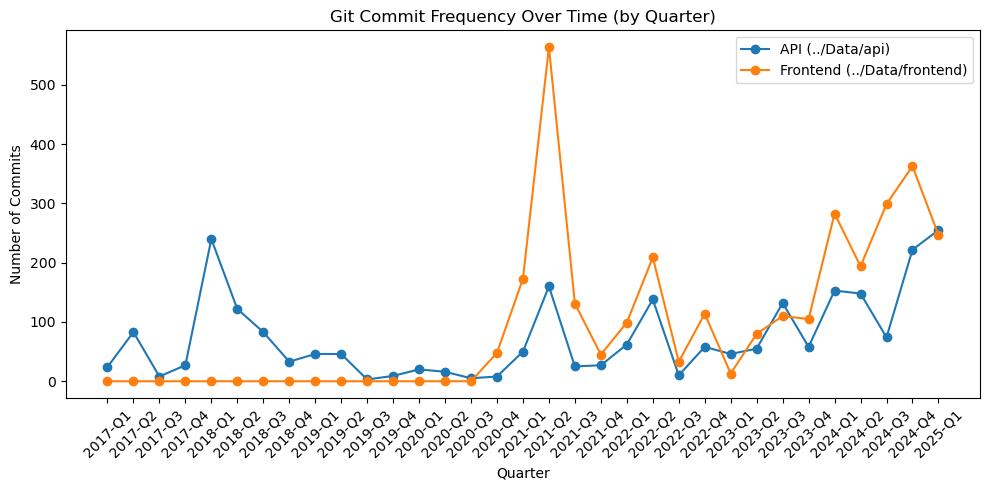

In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime

def get_commit_counts_by_quarter(repo):
    counts = defaultdict(int)
    commits = list(repo.iter_commits())
    for commit in commits:
        dt = datetime.datetime.fromtimestamp(commit.committed_date)
        quarter = (dt.month - 1) // 3 + 1
        quarter_label = f"{dt.year}-Q{quarter}"
        counts[quarter_label] += 1
    return counts

# Get commit counts for each repository by quarter
api_counts = get_commit_counts_by_quarter(repo_api)
frontend_counts = get_commit_counts_by_quarter(repo_frontend)

# Combine quarters from both repos and sort them
quarters = sorted(set(list(api_counts.keys()) + list(frontend_counts.keys())))
api_values = [api_counts.get(q, 0) for q in quarters]
frontend_values = [frontend_counts.get(q, 0) for q in quarters]

# Plot commit frequency over time by quarter
plt.figure(figsize=(10, 5))
plt.plot(quarters, api_values, label='API (../Data/api)', marker='o')
plt.plot(quarters, frontend_values, label='Frontend (../Data/frontend)', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Number of Commits')
plt.title('Git Commit Frequency Over Time (by Quarter)')
plt.legend()
plt.tight_layout()
plt.show()


## File Change Trends Analysis
This section calculates the average number of files changed per commit over time for each repository.

In [3]:
def get_file_change_trends(repo):
    changes = defaultdict(list)
    commits = list(repo.iter_commits())
    for commit in commits:
        dt = datetime.datetime.fromtimestamp(commit.committed_date)
        month = dt.strftime('%Y-%m')
        try:
            file_changes = commit.stats.total.get('files', 0)
        except Exception:
            file_changes = 0
        changes[month].append(file_changes)
    avg_changes = {month: sum(changes[month]) / len(changes[month]) for month in changes if changes[month]}
    return avg_changes

api_file_changes = get_file_change_trends(repo_api)
frontend_file_changes = get_file_change_trends(repo_frontend)

all_months = sorted(set(list(api_file_changes.keys()) + list(frontend_file_changes.keys())))
api_avg = [api_file_changes.get(month, 0) for month in all_months]
frontend_avg = [frontend_file_changes.get(month, 0) for month in all_months]

plt.figure(figsize=(10, 5))
plt.plot(all_months, api_avg, label='API (../Data/api)', marker='s')
plt.plot(all_months, frontend_avg, label='Frontend (../Data/frontend)', marker='s')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Files Changed per Commit')
plt.title('File Change Trends Over Time')
plt.legend()
plt.tight_layout()
plt.show()

## Commit Message Keyword Analysis
In this section we search commit messages for keywords related to architectural changes and refactoring. Keywords include **refactor**, **architect**, **modular**, **pattern**, **anti-pattern**, **cleanup**, **performance**, **scalability**.

In [4]:
def analyze_commit_messages(repo, keywords):
    keyword_counts = defaultdict(int)
    commits = list(repo.iter_commits())
    for commit in commits:
        msg = commit.message.lower()
        for keyword in keywords:
            if keyword in msg:
                keyword_counts[keyword] += 1
    return keyword_counts

keywords = ["refactor", "architect", "modular", "pattern", "anti-pattern", "cleanup", "performance", "scalability"]

api_keyword_counts = analyze_commit_messages(repo_api, keywords)
frontend_keyword_counts = analyze_commit_messages(repo_frontend, keywords)

def plot_keyword_counts(keyword_counts, title):
    keys = list(keyword_counts.keys())
    values = [keyword_counts[k] for k in keys]
    plt.figure(figsize=(8, 4))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Keyword')
    plt.ylabel('Occurrences')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_keyword_counts(api_keyword_counts, 'API (../Data/api) Commit Message Keywords')
plot_keyword_counts(frontend_keyword_counts, 'Frontend (../Data/frontend) Commit Message Keywords')

## Additional Interesting Cases
The following analyses include:

1. **Commits by Author:** Which authors have been driving changes?
2. **Issue Reference Extraction:** Extraction of issue references (e.g., `#123`) from commit messages.

In [5]:
from collections import Counter
import re

def analyze_commits_by_author(repo):
    authors = Counter()
    commits = list(repo.iter_commits())
    for commit in commits:
        authors[commit.author.name] += 1
    return authors

def plot_authors(author_counts, title):
    authors = list(author_counts.keys())
    counts = list(author_counts.values())
    plt.figure(figsize=(8, 4))
    plt.bar(authors, counts, color='lightgreen')
    plt.xlabel('Author')
    plt.ylabel('Number of Commits')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analyze and plot commits by author for both repositories
api_authors = analyze_commits_by_author(repo_api)
frontend_authors = analyze_commits_by_author(repo_frontend)

plot_authors(api_authors, 'Commits by Author - API (../Data/api)')
plot_authors(frontend_authors, 'Commits by Author - Frontend (../Data/frontend)')

def analyze_issue_references(repo):
    issue_counts = defaultdict(int)
    issue_commits = defaultdict(list)
    commits = list(repo.iter_commits())
    for commit in commits:
        issues = re.findall(r"#(\d+)", commit.message)
        for issue in issues:
            issue_counts[issue] += 1
            issue_commits[issue].append(commit.hexsha[:7])
    return issue_counts, issue_commits

# Analyze issue references for both repositories
api_issue_counts, api_issue_commits = analyze_issue_references(repo_api)
frontend_issue_counts, frontend_issue_commits = analyze_issue_references(repo_frontend)

def plot_issue_counts(issue_counts, title):
    issues = list(issue_counts.keys())
    counts = [issue_counts[k] for k in issues]
    plt.figure(figsize=(8, 4))
    plt.bar(issues, counts, color='coral')
    plt.xlabel('Issue ID')
    plt.ylabel('Number of References')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_issue_counts(api_issue_counts, 'Issue References in API (../Data/api)')
plot_issue_counts(frontend_issue_counts, 'Issue References in Frontend (../Data/frontend)')

if api_issue_commits:
    sample_issue = list(api_issue_commits.keys())[0]
    print(f"API: Sample commits referencing issue #{sample_issue}:", api_issue_commits[sample_issue])
if frontend_issue_commits:
    sample_issue = list(frontend_issue_commits.keys())[0]
    print(f"Frontend: Sample commits referencing issue #{sample_issue}:", frontend_issue_commits[sample_issue])

## Interesting Cases Summary
Review the debug output and visualizations. If no commits are printed in the debug section, ensure that the specified repository paths are correct and that the repositories contain commit history.